<a href="https://colab.research.google.com/github/timmooren/hispa-cancer-detection/blob/main/code/hispa_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Histopathologic Cancer Detection




In [4]:
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
from google.colab import files

# Downloading data

The cell below will promt you for a kaggle.json file. This file is needed for the Kaggle API.
For more information on how to download your own kaggle.json file, please see:
https://www.kaggle.com/docs/api

In [2]:
#this will prompt you to upload the kaggle.json
files.upload()  

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"timomarmooren","key":"3faa9098cc7ca6d76d3804bc9f4bb31b"}'}

The cell below will install the Kaggle package and move kaggle.json to the appropriate folder.

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

     |████████████████████████████████| 61kB 4.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=a8c83a90e7543804b1bca4ee32f518665ecd9410e93e036df8397b046ebb95c6
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json


The cell below downloads and unzips the data

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection
!unzip histopathologic-cancer-detection.zip

100% 6.31G/6.31G [02:21<00:00, 59.4MB/s]
100% 6.31G/6.31G [02:21<00:00, 47.8MB/s]


# Loading data

Load train_labels.csv and image id's to their respective label.

In [5]:
labels_csv = pd.read_csv('train_labels.csv')
id2label = dict(zip(labels_csv.id, labels_csv.label))

Get the filepaths of all the images and divide them into training and validation data.

In [6]:
# get filepaths of all the images
file_paths = glob.glob('train/*.tif')
# split the filepaths into train and validation data
train_paths, val_paths = train_test_split(file_paths, test_size=0.3, random_state=10)

In [8]:
def load_data(image_paths):
  """
  Prepares data for training or validation.

  Arguments: File paths of relevant images.

  Returns: A tuple containing:
    - Four dimensional Numpy array containing all the images (ready for training).
    - Targets as
  """
  image_list, target_list = [], []

  for image_path in image_paths:
          # image id is equal to the filename
          id = image_path[6:-4]
          # get relevant label
          target = id2label[id]
          # add image to the list
          image_list.append(cv2.resize(cv2.imread(image_path), (32, 32)))
          # add target to the list
          target_list.append(target)

  # convert to one-hot encoding
  targets = tf.keras.utils.to_categorical(target_list)

  return (np.array(image_list), targets)


train_images, train_labels = load_data(train_paths)
val_images, val_labels = load_data(val_paths)

print(f'Training images loaded: {train_images.shape}')
print(f'Training labels loaded: {train_labels.shape}')
print(f'Testing images loaded: {val_images.shape}')
print(f'Testing labels loaded: {val_labels.shape}')

Training images loaded: (154017, 32, 32, 3)
Training labels loaded: (154017, 2)
Testing images loaded: (66008, 32, 32, 3)
Testing labels loaded: (66008, 2)


Source of code below: CNN_gtsrb notebook.

---



In [9]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}, l_rate=0.001):
    """
    Trains and evaluates a model based on training and testing data, and their respective labels.
    Preprocessing and data augmentation can be added trough their respective arguments.
    """
    opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

# Model 1a: Base model with learning rate = 0.001



For our base model, we made a convolutional neural network with the following architecture:

- 2 convolutional and max pooling layers
- 1 flatten layer
- 1 hidden layer
- 1 output layer

Epoch 1/20
4814/4814 [==============================] - 99s 14ms/step - loss: 0.6274 - accuracy: 0.7742 - val_loss: 0.4666 - val_accuracy: 0.7969
Epoch 2/20
4814/4814 [==============================] - 74s 15ms/step - loss: 0.4380 - accuracy: 0.8031 - val_loss: 0.4391 - val_accuracy: 0.8063
Epoch 3/20
4814/4814 [==============================] - 65s 14ms/step - loss: 0.4116 - accuracy: 0.8160 - val_loss: 0.4155 - val_accuracy: 0.8230
Epoch 4/20
4814/4814 [==============================] - 65s 14ms/step - loss: 0.3968 - accuracy: 0.8238 - val_loss: 0.3879 - val_accuracy: 0.8296
Epoch 5/20
4814/4814 [==============================] - 65s 14ms/step - loss: 0.3880 - accuracy: 0.8271 - val_loss: 0.3901 - val_accuracy: 0.8291
Epoch 6/20
4814/4814 [==============================] - 60s 13ms/step - loss: 0.3796 - accuracy: 0.8320 - val_loss: 0.3938 - val_accuracy: 0.8291
Epoch 7/20
4814/4814 [==============================] - 60s 13ms/step - loss: 0.3736 - accuracy: 0.8354 - val_loss: 0.3867 -

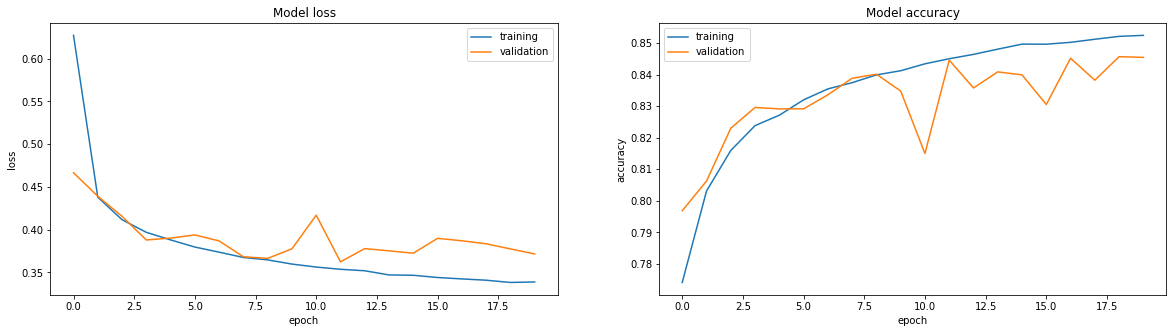

2063/2063 [==============================] - 9s 4ms/step - loss: 0.3715 - accuracy: 0.8454
Validation Accuracy: 0.8454278111457825


In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels)

**Analysis of the graph above (Baseline model):**

Although the training and validation accuracy is increasing in the first 20 epochs, the slope of both lines becomes rather flat. In order to increase the speed of learning, we will preprocess the data in the next cell.

# Model 1b: Base model with learning rate = 0.01


Epoch 1/20
4814/4814 [==============================] - 73s 9ms/step - loss: 1.1980 - accuracy: 0.7475 - val_loss: 0.6315 - val_accuracy: 0.6528
Epoch 2/20
4814/4814 [==============================] - 41s 8ms/step - loss: 0.5918 - accuracy: 0.6834 - val_loss: 0.6786 - val_accuracy: 0.5942
Epoch 3/20
4814/4814 [==============================] - 40s 8ms/step - loss: 0.6756 - accuracy: 0.5953 - val_loss: 0.6753 - val_accuracy: 0.5942
Epoch 4/20
4814/4814 [==============================] - 40s 8ms/step - loss: 0.6753 - accuracy: 0.5953 - val_loss: 0.6753 - val_accuracy: 0.5942
Epoch 5/20
4814/4814 [==============================] - 40s 8ms/step - loss: 0.6752 - accuracy: 0.5953 - val_loss: 0.6754 - val_accuracy: 0.5942
Epoch 6/20
4814/4814 [==============================] - 40s 8ms/step - loss: 0.6753 - accuracy: 0.5953 - val_loss: 0.6753 - val_accuracy: 0.5942
Epoch 7/20
4814/4814 [==============================] - 40s 8ms/step - loss: 0.6753 - accuracy: 0.5953 - val_loss: 0.6763 - val_ac

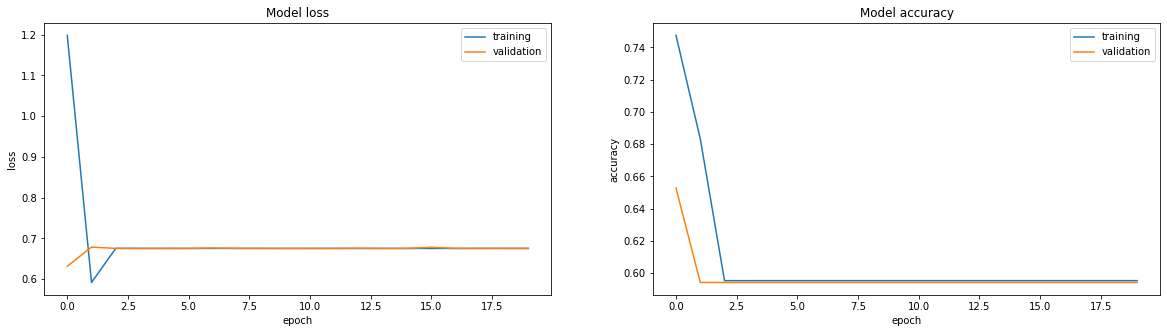

2063/2063 [==============================] - 9s 4ms/step - loss: 0.6755 - accuracy: 0.5942
Validation Accuracy: 0.5941855311393738


In [10]:
# base model with different learning rate
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, l_rate=0.01)

**Analysis of graph above (Baseline model wiht learning rate = 0.01):**

Increasing the learning rate from 0.001 to 0.01 is definitely not an improvement on the previous model.

# Model 2: Preprocessing



In order to make the network learn faster, we applied featurewise center and featurewise standard normalization to the input images.

Epoch 1/20
4814/4814 [==============================] - 81s 11ms/step - loss: 0.4443 - accuracy: 0.7973 - val_loss: 0.3894 - val_accuracy: 0.8269
Epoch 2/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3900 - accuracy: 0.8263 - val_loss: 0.3732 - val_accuracy: 0.8360
Epoch 3/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3676 - accuracy: 0.8378 - val_loss: 0.3764 - val_accuracy: 0.8398
Epoch 4/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3454 - accuracy: 0.8496 - val_loss: 0.3441 - val_accuracy: 0.8502
Epoch 5/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3298 - accuracy: 0.8566 - val_loss: 0.3571 - val_accuracy: 0.8481
Epoch 6/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3152 - accuracy: 0.8632 - val_loss: 0.3394 - val_accuracy: 0.8529
Epoch 7/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3010 - accuracy: 0.8707 - val_loss: 0.3416 -

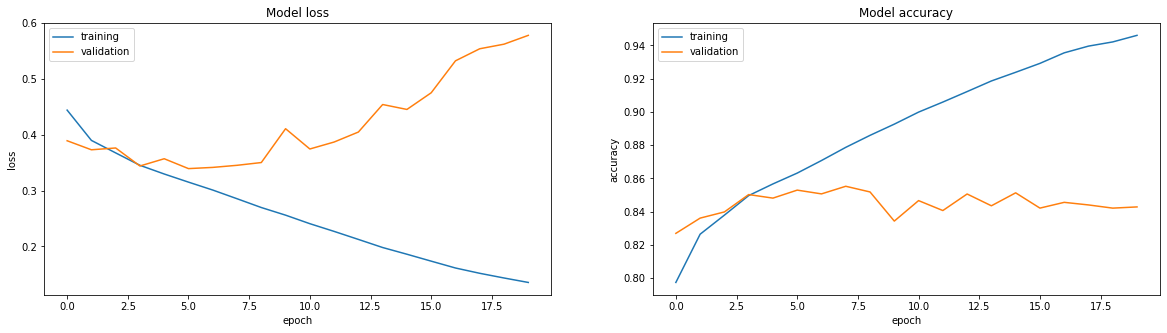

2063/2063 [==============================] - 10s 5ms/step - loss: 0.5782 - accuracy: 0.8428
Validation Accuracy: 0.8427766561508179


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True})

**Analysis of above graph:**

Thanks to the normalization of the input data, the network was able to learn much quicker. This can be seen by the rapid increase in validation accuracy as compared to the previous model. 

However, the validation accuracy reaches a plateau at some point, while the training data increases steadily. This is a sign that the model is overfitting to the training data. The overfitting starts around epoch 3 (as seen by the naked eye).

In order to prevent overfitting, we will add dropout to the network in the next cell.

---



# Model 3: Dropout

Epoch 1/20
4814/4814 [==============================] - 58s 12ms/step - loss: 0.4599 - accuracy: 0.7897 - val_loss: 0.4111 - val_accuracy: 0.8158
Epoch 2/20
4814/4814 [==============================] - 49s 10ms/step - loss: 0.4183 - accuracy: 0.8139 - val_loss: 0.4028 - val_accuracy: 0.8194
Epoch 3/20
4814/4814 [==============================] - 49s 10ms/step - loss: 0.4021 - accuracy: 0.8225 - val_loss: 0.3725 - val_accuracy: 0.8365
Epoch 4/20
4814/4814 [==============================] - 49s 10ms/step - loss: 0.3899 - accuracy: 0.8270 - val_loss: 0.3725 - val_accuracy: 0.8329
Epoch 5/20
4814/4814 [==============================] - 49s 10ms/step - loss: 0.3808 - accuracy: 0.8329 - val_loss: 0.3596 - val_accuracy: 0.8450
Epoch 6/20
4814/4814 [==============================] - 49s 10ms/step - loss: 0.3726 - accuracy: 0.8370 - val_loss: 0.3593 - val_accuracy: 0.8404
Epoch 7/20
4814/4814 [==============================] - 49s 10ms/step - loss: 0.3711 - accuracy: 0.8380 - val_loss: 0.3659 -

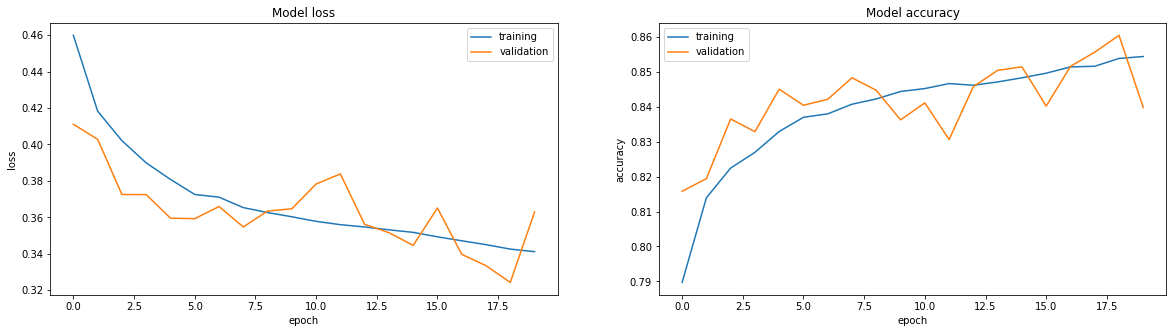

2063/2063 [==============================] - 11s 5ms/step - loss: 0.3629 - accuracy: 0.8398
Validation Accuracy: 0.8397921323776245


In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#added
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# added
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}) 